In [28]:
import os
os.chdir('..\\') # in ./tests folder - so changing to parent folder for imports

from consts import FOLDER2FLOW_RESULTS
import pandas as pd
import pprint
import matplotlib.pyplot as plt
from IPython.display import display

class df_extra:    
    def __init__(self, df):
        self.df = df
        self.num_rows = df.shape[0]
        self.data_dict = {}

    def add_data_to_df(self, col_name, data):
        self.data_dict[col_name] = [data]*self.num_rows
        self.df[col_name] = data

def create_united_df(date_folder, timelimit=600): # This is a df of all networks in folder
    res_dp = os.path.join(FOLDER2FLOW_RESULTS, date_folder)
    dfs_list = []
    for network in sorted(os.listdir(res_dp), reverse=True):
        df_fp = os.path.join(res_dp, network, "results.df")
        if network.endswith(".log") or not os.path.exists(df_fp):
            continue
        df = pd.read_pickle(df_fp)

        _df_extra = df_extra(df)
        _df_extra.add_data_to_df("network", network)
        _df_extra.add_data_to_df("mu", network.split("_")[1])

        dfs_list.append(df)
    df = pd.concat(dfs_list)
    df.reset_index(inplace=True)
    del df["index"]
    
    # replace names to shorter names for readabilty
    df["algo"].replace(f"NLP-100-TL-{timelimit}", "NLP100", inplace=True)
    df["algo"].replace(f"NLP-150-TL-{timelimit}", "NLP150", inplace=True)
    df["algo"].replace(f"NLP-200-TL-{timelimit}", "NLP200", inplace=True)
    
    df["algo"].replace(f"LLP-100", "LLP100", inplace=True)
    df["algo"].replace(f"louvain-ILP-num_com_bound 150", "LLP150", inplace=True)
    df["algo"].replace(f"louvain-ILP-num_com_bound 200", "LLP200", inplace=True)
    
    return df

def prepare_data_for_plot_per_mu(df):
    evals = ["avg_modularity", "std_modularity", "avg_jaccard", "std_jaccard"]
    mus = ["all", "0.4", "0.5", "0.6"]
    evals_dict = {}

    for mu in mus:
        evals_dict[mu] = {}
        for _eval in evals:
            evals_dict[mu][_eval] = {}

    for algo in df.algo.unique():
        for mu, evals in evals_dict.items():
    #         print(algo, mu)
            if mu == "all":
                algo_rows = df.loc[df["algo"]==algo]
            else:
                algo_rows = df.loc[df["algo"]==algo].loc[df["mu"]==mu]

            avg_modularity = algo_rows["modularity - algo"].mean()
            std_modularity = algo_rows["modularity - algo"].std()
            avg_jaccard = algo_rows["jaccard"].mean()
            std_jaccard = algo_rows["jaccard"].std()

            evals["avg_modularity"][algo] = avg_modularity
            evals["std_modularity"][algo] = std_modularity
            evals["avg_jaccard"][algo] = avg_jaccard
            evals["std_jaccard"][algo] = std_jaccard
    return evals_dict

def prepare_data_for_plot_per_eval(df):
    evals_dict = {}
    evals = ["avg_modularity", "std_modularity", "avg_jaccard", "std_jaccard"]
    mus = ["0.4", "0.5", "0.6"]
    for _eval in evals:
        evals_dict[_eval] = {}
        for mu in mus:
            evals_dict[_eval][mu] = df.loc
    

def create_plots(data_for_plot):
    for mu, mu_evals in data_for_plot.items():
        for eval_name, eval_data in mu_evals.items():
            fig, ax = plt.subplots()
            ax.set_title(f'{eval_name}, mu={mu}')
            x = eval_data.values()
            y = eval_data.keys()
            ax.plot(y, x)
#             ax.axhline(y=list(x)[0], color='r', linestyle='--')

def run_visu(date_folder):
    df = create_united_df(date_folder)
    display(df)
    data_for_plots = prepare_data_for_plot_per_mu(df)
    print(data_for_plots)
    create_plots(data_for_plots)

In [88]:
def create_plot_all_mus(df, ev_col="modularity - algo", plot_name="avg modularity per mu", num=0):
    mus = ["0.4", "0.5", "0.6"]
        
    fig, ax = plt.subplots()
    ax.set_title(f'{plot_name}')

    for algo in df.algo.unique():
        x = [] # mus
        y = [] # evals per mu
    
        # avg_modularity
        for mu in mus:
            x.append(mu)
            #algo_rows = df.loc[df["algo"]==algo].loc[df["mu"]==mu].loc[df["num communities - algo"]!=df["number_of_mega_nodes"]]
            algo_rows = df.loc[df["mu"]==mu].loc[df["algo"]==algo]
            
            if algo != "Louvain":
                algo_rows = algo_rows.loc[df["number_of_mega_nodes"]-df["num communities - algo"]>=num]
            
            algo_eval_rows = algo_rows[ev_col]
            #print(algo_eval_rows)
            y.append(algo_eval_rows.mean())
        print(x,y)
        ax.plot(x, y, label=algo)
        ax.legend()

        
def create_graph(date_folder, ev_col="modularity - algo", plot_name="avg modularity per mu", num=0):
    df = create_united_df(date_folder)
    #display(df)
    create_plot_all_mus(df, ev_col, plot_name,  num)
    return df

In [86]:
date_1000_nodes_folder = "26-05-2022--15-13-20-louvain-1000" 

['0.4', '0.5', '0.6'] [0.9501532257294579, 0.8492083605888305, 0.5080881270798547]
['0.4', '0.5', '0.6'] [0.9331539453052424, 0.8379066881227457, 0.5466079047929469]


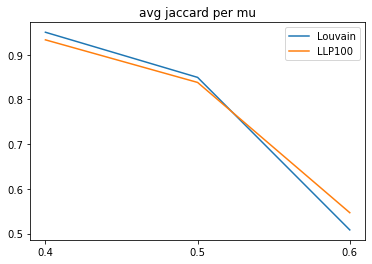

In [89]:
df = create_graph(date_1000_nodes_folder, ev_col="jaccard", plot_name="avg jaccard per mu", num=2)

['0.4', '0.5', '0.6'] [0.5653778215941644, 0.4639675837881591, 0.3591827522153372]
['0.4', '0.5', '0.6'] [0.5656028686123309, 0.46372052711431694, 0.3596055465343475]


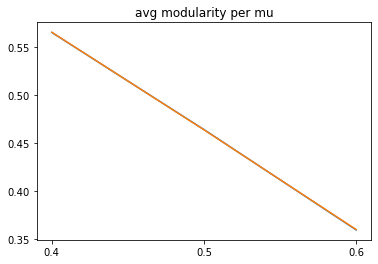

In [72]:
df = create_graph(date_1000_nodes_folder, num=2)

['0.4', '0.5', '0.6'] [0.5653778215941644, 0.4639675837881591, 0.3591827522153372]
['0.4', '0.5', '0.6'] [0.5657420185582512, 0.4637964250893912, 0.35962249852534195]


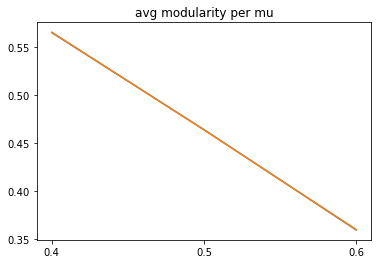

In [74]:
df = create_graph(date_1000_nodes_folder, num=5)

In [75]:
df

,algo,modularity - real,modularity - algo,jaccard,graph_conductance,graph_sensitivity,graph_accuracy,num communities - real,num communities - algo,num_coms_divided,num_coms_skipped,number_of_mega_nodes,iterations,time-sec,network,mu
0,Louvain,0.363148,0.359769,0.514590,0.414455,0.974,0.827479,30,20,None,None,NaN,NaN,0.170578,1000_0.6_9,0.6
1,LLP100,0.363148,0.360630,0.476668,0.419483,0.972,0.800342,30,19,None,None,31.0,1.0,0.620861,1000_0.6_9,0.6
2,LLP100,0.363148,0.366264,0.590537,0.417554,0.981,0.844504,30,20,None,None,35.0,1.0,0.735362,1000_0.6_9,0.6
3,LLP100,0.363148,0.360157,0.553905,0.410523,0.956,0.839388,30,21,None,None,32.0,1.0,0.699961,1000_0.6_9,0.6
4,LLP100,0.363148,0.361996,0.519911,0.418192,0.973,0.812814,30,19,None,None,35.0,1.0,0.660898,1000_0.6_9,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,LLP100,0.564733,0.565410,0.886834,0.603145,1.000,0.965919,31,28,None,None,33.0,1.0,0.573977,1000_0.4_0,0.4
326,LLP100,0.564733,0.565410,0.886834,0.603145,1.000,0.965919,31,28,None,None,31.0,1.0,0.407282,1000_0.4_0,0.4
327,LLP100,0.564733,0.565410,0.886834,0.603145,1.000,0.965919,31,28,None,None,32.0,1.0,0.498012,1000_0.4_0,0.4
328,LLP100,0.564733,0.565410,0.886834,0.603145,1.000,0.965919,31,28,None,None,32.0,1.0,0.505108,1000_0.4_0,0.4


In [76]:
df.loc[df["mu"]=="0.6"].loc[df["algo"]=="Louvain"]

,algo,modularity - real,modularity - algo,jaccard,graph_conductance,graph_sensitivity,graph_accuracy,num communities - real,num communities - algo,num_coms_divided,num_coms_skipped,number_of_mega_nodes,iterations,time-sec,network,mu
0,Louvain,0.363148,0.359769,0.514590,0.414455,0.974,0.827479,30,20,None,None,NaN,NaN,0.170578,1000_0.6_9,0.6
11,Louvain,0.362887,0.355409,0.507764,0.411736,0.940,0.817521,28,19,None,None,NaN,NaN,0.164313,1000_0.6_8,0.6
22,Louvain,0.363978,0.359518,0.549118,0.409859,0.955,0.825754,30,21,None,None,NaN,NaN,0.181562,1000_0.6_7,0.6
33,Louvain,0.364689,0.357484,0.490572,0.412380,0.950,0.801966,30,20,None,None,NaN,NaN,0.155585,1000_0.6_6,0.6
44,Louvain,0.365454,0.365920,0.561358,0.416663,0.980,0.821121,32,20,None,None,NaN,NaN,0.166772,1000_0.6_5,0.6
55,Louvain,0.362392,0.359312,0.601991,0.409739,0.967,0.850480,29,21,None,None,NaN,NaN,0.168754,1000_0.6_4,0.6
66,Louvain,0.363363,0.356497,0.427093,0.422059,0.956,0.738834,30,16,None,None,NaN,NaN,0.165247,1000_0.6_3,0.6
77,Louvain,0.363717,0.357477,0.461831,0.411599,0.958,0.804146,30,19,None,None,NaN,NaN,0.218678,1000_0.6_2,0.6
88,Louvain,0.365939,0.359437,0.462991,0.418756,0.971,0.777774,32,19,None,None,NaN,NaN,0.181414,1000_0.6_1,0.6
99,Louvain,0.365902,0.361004,0.503573,0.413572,0.966,0.811077,31,20,None,None,NaN,NaN,0.196040,1000_0.6_0,0.6


In [77]:
df.loc[df["mu"]=="0.6"].loc[df["algo"]=="LLP100"]

,algo,modularity - real,modularity - algo,jaccard,graph_conductance,graph_sensitivity,graph_accuracy,num communities - real,num communities - algo,num_coms_divided,num_coms_skipped,number_of_mega_nodes,iterations,time-sec,network,mu
1,LLP100,0.363148,0.360630,0.476668,0.419483,0.972,0.800342,30,19,None,None,31.0,1.0,0.620861,1000_0.6_9,0.6
2,LLP100,0.363148,0.366264,0.590537,0.417554,0.981,0.844504,30,20,None,None,35.0,1.0,0.735362,1000_0.6_9,0.6
3,LLP100,0.363148,0.360157,0.553905,0.410523,0.956,0.839388,30,21,None,None,32.0,1.0,0.699961,1000_0.6_9,0.6
4,LLP100,0.363148,0.361996,0.519911,0.418192,0.973,0.812814,30,19,None,None,35.0,1.0,0.660898,1000_0.6_9,0.6
5,LLP100,0.363148,0.365514,0.588521,0.416962,0.981,0.843342,30,20,None,None,31.0,1.0,0.547045,1000_0.6_9,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,LLP100,0.365902,0.366478,0.529154,0.419675,0.984,0.816794,31,20,None,None,33.0,1.0,0.609740,1000_0.6_0,0.6
106,LLP100,0.365902,0.351350,0.384782,0.415468,0.914,0.721789,31,17,None,None,39.0,1.0,1.740038,1000_0.6_0,0.6
107,LLP100,0.365902,0.351536,0.422460,0.409844,0.893,0.746480,31,18,None,None,50.0,1.0,7.092636,1000_0.6_0,0.6
108,LLP100,0.365902,0.358001,0.484310,0.412909,0.946,0.792555,31,20,None,None,30.0,1.0,0.472159,1000_0.6_0,0.6


,algo,modularity - real,modularity - algo,jaccard,graph_conductance,graph_sensitivity,graph_accuracy,num communities - real,num communities - algo,num_coms_divided,num_coms_skipped,number_of_mega_nodes,iterations,time-sec,network,mu
0,Louvain,0.363148,0.360611,0.551136,0.416218,0.975,0.830843,30,20,None,None,NaN,NaN,0.153312,1000_0.6_9,0.6
1,LLP100,0.363148,0.359684,0.465487,0.419414,0.970,0.794040,30,18,None,None,34.0,1.0,0.550816,1000_0.6_9,0.6
2,Louvain,0.362887,0.355744,0.533280,0.410737,0.951,0.836053,28,20,None,None,NaN,NaN,0.148417,1000_0.6_8,0.6
3,LLP100,0.362887,0.363407,0.773893,0.407607,0.991,0.927463,28,23,None,None,29.0,1.0,0.424295,1000_0.6_8,0.6
4,Louvain,0.363978,0.362054,0.643233,0.409781,0.983,0.886238,30,23,None,None,NaN,NaN,0.181637,1000_0.6_7,0.6
5,LLP100,0.363978,0.350821,0.453867,0.407811,0.904,0.779415,30,19,None,None,26.0,1.0,0.409408,1000_0.6_7,0.6
6,Louvain,0.364689,0.358364,0.470920,0.412012,0.971,0.819715,30,21,None,None,NaN,NaN,0.161917,1000_0.6_6,0.6
7,LLP100,0.364689,0.358423,0.551356,0.407557,0.948,0.835301,30,22,None,None,34.0,1.0,0.811911,1000_0.6_6,0.6
8,Louvain,0.365454,0.360356,0.504603,0.413076,0.959,0.802178,32,20,None,None,NaN,NaN,0.165353,1000_0.6_5,0.6
9,LLP100,0.365454,0.360615,0.472103,0.417825,0.976,0.776639,32,19,None,None,35.0,1.0,0.853001,1000_0.6_5,0.6


{'all': {'avg_modularity': {'Louvain': 0.4632393084015976, 'LLP100': 0.4629235125322969}, 'std_modularity': {'Louvain': 0.08489429875061114, 'LLP100': 0.08545214884300882}, 'avg_jaccard': {'Louvain': 0.7774130134229316, 'LLP100': 0.776068701787713}, 'std_jaccard': {'Louvain': 0.16729203100340104, 'LLP100': 0.18848362672752736}}, '0.4': {'avg_modularity': {'Louvain': 0.5652043244186066, 'LLP100': 0.565249048202153}, 'std_modularity': {'Louvain': 0.0021936477947368713, 'LLP100': 0.0024880338832705424}, 'avg_jaccard': {'Louvain': 0.9348646187829839, 'LLP100': 0.946189390945593}, 'std_jaccard': {'Louvain': 0.05792833537304381, 'LLP100': 0.035827397710690295}}, '0.5': {'avg_modularity': {'Louvain': 0.4636917230974754, 'LLP100': 0.4638682630894687}, 'std_modularity': {'Louvain': 0.001360158881606647, 'LLP100': 0.001935854597964986}, 'avg_jaccard': {'Louvain': 0.8310574140596408, 'LLP100': 0.8397987935280847}, 'std_jaccard': {'Louvain': 0.05537165179694887, 'LLP100': 0.04538863688569801}}, '0

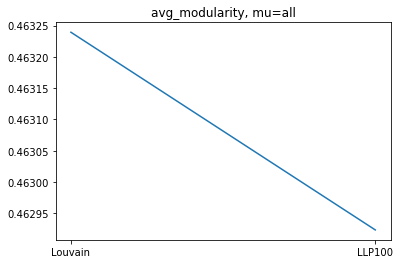

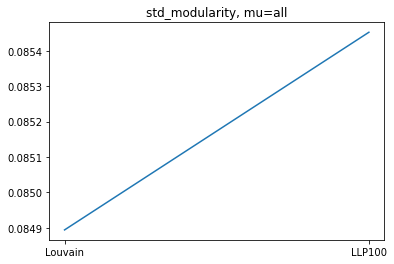

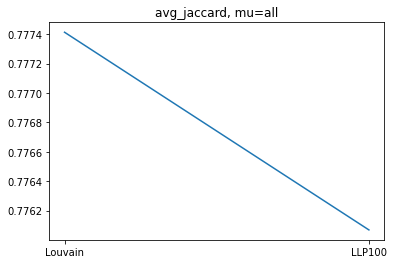

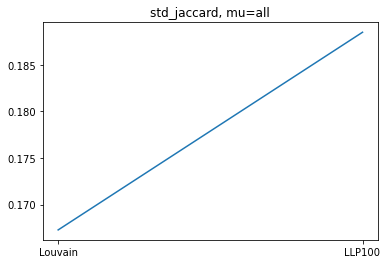

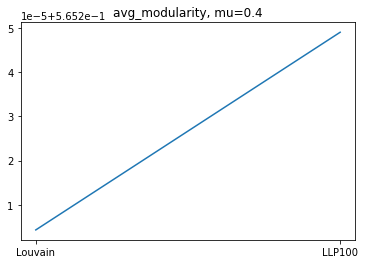

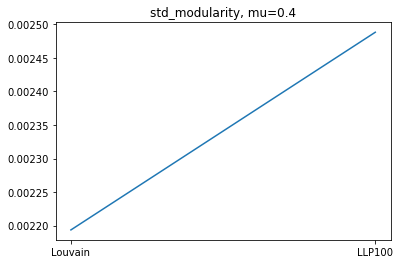

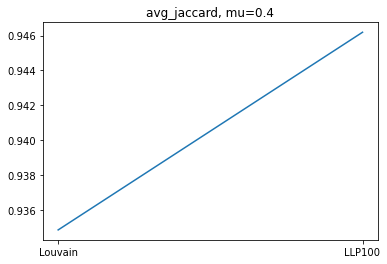

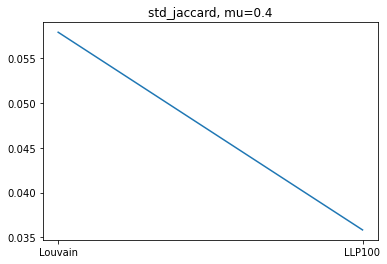

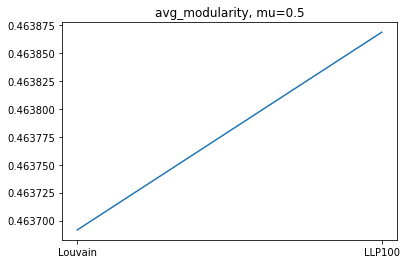

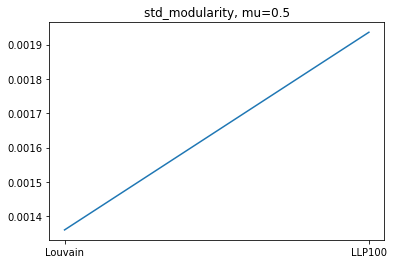

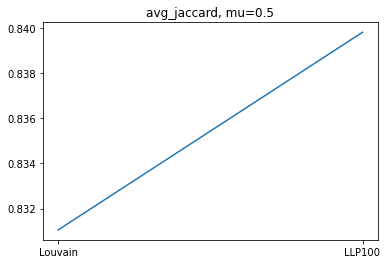

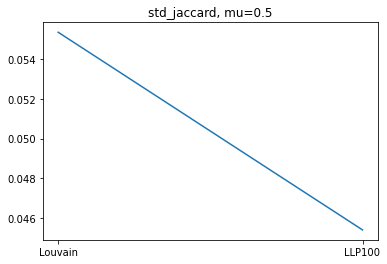

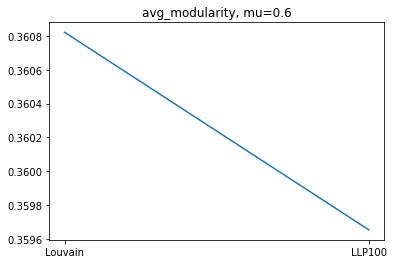

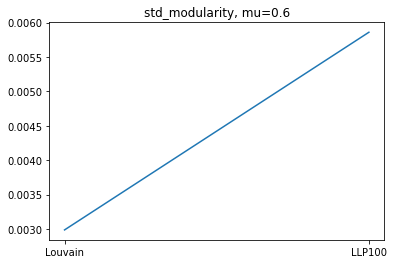

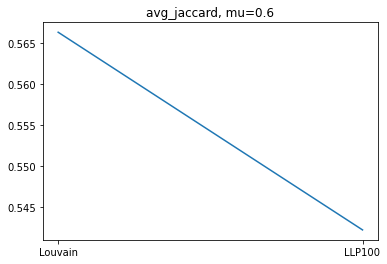

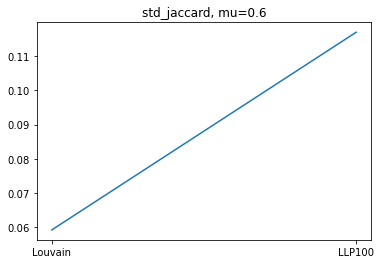

In [5]:
# date_folder = "17-05-2022--13-36-06"
date_1000_nodes_folder = "26-05-2022--11-57-42" 
run_visu(date_1000_nodes_folder)

TODO: create 1 graph of 6 points - 3 mu of real louvain, 3 mu of ilp-louvain
- print out average mega_graph size
- run in flow 10 runs per network, in order to average here...
- create graphs for 10,000 nodes - 
- maybe better for 10,000: change louvain code to run according to lp_critical= num iterations and not num_nodes. 